# 02 - Reinforcement Learning - Evolving MLP [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/02_rl.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX on NVIDIA GPU with:

In [ ]:
%pip install -U "jax[cuda]"

Then, install `evosax` from PyPi:

In [ ]:
%pip install -U "evosax[examples]"

## Import

In [1]:
import jax
import matplotlib.pyplot as plt
import optax

In [2]:
seed = 0
key = jax.random.key(seed)

## Gymnax

### CartPole environment

In [3]:
from evosax.problems import GymnaxProblem as Problem
from evosax.problems.networks import MLP, categorical_output_fn

policy = MLP(
    layer_sizes=(64, 64, 2),
    output_fn=categorical_output_fn,
)

problem = Problem(
    env_name="CartPole-v1",
    policy=policy,
    episode_length=200,
    num_rollouts=16,
    use_normalize_obs=True,
)

key, subkey = jax.random.split(key)
problem_state = problem.init(key)

key, subkey = jax.random.split(key)
solution = problem.sample(subkey)

In [4]:
print(f"Number of pararmeters: {sum(leaf.size for leaf in jax.tree.leaves(solution))}")

Number of pararmeters: 4610


### SNES

In [5]:
from evosax.algorithms import SNES as ES

num_generations = 64
population_size = 128

es = ES(
    population_size=population_size,
    solution=solution,
    optimizer=optax.adam(learning_rate=0.01),
)

params = es.default_params

### Run

In [6]:
def step(carry, key):
    state, params, problem_state = carry
    key_ask, key_eval, key_tell = jax.random.split(key, 3)

    population, state = es.ask(key_ask, state, params)

    fitness, problem_state, _ = problem.eval(key_eval, population, problem_state)

    state, metrics = es.tell(
        key_tell, population, -fitness, state, params
    )  # Minimize fitness

    return (state, params, problem_state), metrics

In [7]:
key, subkey = jax.random.split(key)
state = es.init(subkey, solution, params)

key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_generations)
_, metrics = jax.lax.scan(
    step,
    (state, params, problem_state),
    keys,
)

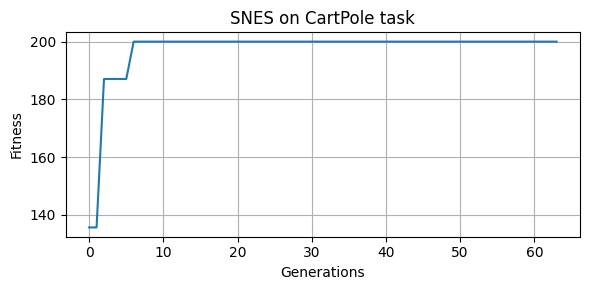

In [8]:
plt.figure(figsize=(6, 3))
plt.plot(-metrics["best_fitness"])

plt.title("SNES on CartPole task")
plt.xlabel("Generations")
plt.ylabel("Fitness")

plt.grid(True)
plt.tight_layout()

plt.show()

## Brax

### Ant environment

In [3]:
from evosax.problems import BraxProblem as Problem
from evosax.problems.networks import MLP, tanh_output_fn

policy = MLP(
    layer_sizes=(32, 32, 32, 32, 8),
    output_fn=tanh_output_fn,
)

problem = Problem(
    env_name="ant",
    policy=policy,
    episode_length=1000,
    num_rollouts=16,
    use_normalize_obs=True,
)

key, subkey = jax.random.split(key)
problem_state = problem.init(key)

key, subkey = jax.random.split(key)
solution = problem.sample(subkey)

In [4]:
print(f"Number of pararmeters: {sum(leaf.size for leaf in jax.tree.leaves(solution))}")

Number of pararmeters: 4328


### Open_ES

In [5]:
from evosax.algorithms import Open_ES as ES

num_generations = 512
population_size = 256

lr_schedule = optax.exponential_decay(
    init_value=0.01,
    transition_steps=num_generations,
    decay_rate=0.1,
)
std_schedule = optax.exponential_decay(
    init_value=0.05,
    transition_steps=num_generations,
    decay_rate=0.2,
)
es = ES(
    population_size=population_size,
    solution=solution,
    optimizer=optax.adam(learning_rate=lr_schedule),
    std_schedule=std_schedule,
)

params = es.default_params

### Run

In [6]:
def step(carry, key):
    state, params, problem_state = carry
    key_ask, key_eval, key_tell = jax.random.split(key, 3)

    population, state = es.ask(key_ask, state, params)

    fitness, problem_state, _ = problem.eval(key_eval, population, problem_state)

    state, metrics = es.tell(
        key_tell, population, -fitness, state, params
    )  # Minimize fitness

    return (state, params, problem_state), metrics

In [7]:
key, subkey = jax.random.split(key)
state = es.init(subkey, solution, params)

fitness_log = []
log_period = 32
for i in range(num_generations // log_period):
    # Train
    key, subkey = jax.random.split(key)
    keys = jax.random.split(subkey, log_period)
    (state, params, problem_state), metrics = jax.lax.scan(
        step,
        (state, params, problem_state),
        keys,
    )

    # Eval
    mean = es.get_mean(state)
    key, subkey = jax.random.split(key)
    fitness, problem_state, info = problem.eval(
        key, jax.tree.map(lambda x: x[None], mean), problem_state
    )
    print(f"Generation {(i + 1) * log_period:3d} | Mean fitness: {fitness.mean():.2f}")

Generation 032 | Mean fitness: 1467.22
Generation 064 | Mean fitness: 2164.78
Generation 096 | Mean fitness: 3200.59
Generation 128 | Mean fitness: 4063.74
Generation 160 | Mean fitness: 4399.27
Generation 192 | Mean fitness: 4981.06
Generation 224 | Mean fitness: 5477.57
Generation 256 | Mean fitness: 5785.19
Generation 288 | Mean fitness: 6054.14
Generation 320 | Mean fitness: 6180.46
Generation 352 | Mean fitness: 6366.17
Generation 384 | Mean fitness: 6550.94
Generation 416 | Mean fitness: 6705.41
Generation 448 | Mean fitness: 6915.58
Generation 480 | Mean fitness: 7037.18
Generation 512 | Mean fitness: 7133.75


## Visualize policy

In [8]:
mean = es.get_mean(state)
mean = es._unravel_solution(state.best_solution)

key, subkey = jax.random.split(key)
fitness, problem_state, info = problem.eval(
    key, jax.tree.map(lambda x: x[None], mean), problem_state
)
fitness[0]

Array(7081.3047, dtype=float32)

In [9]:
from brax.io import html
from IPython.display import HTML

rollout = [
    jax.tree_util.tree_map(lambda x: x[0, 0, t], info["env_states"].pipeline_state)
    for t in range(200)
]

html_content = html.render(
    problem.env.sys.tree_replace({"opt.timestep": problem.env.dt}), rollout
)
HTML(html_content)

In [10]:
# Write to file
with open("ant_visualization.html", "w") as f:
    f.write(html_content)

print("Visualization saved to 'ant_visualization.html'")

Visualization saved to 'ant_visualization.html'
